# Visualizing what docs are really about with expert.ai
## A brief tutorial on how to retrieve and visualize hidden relevant data in textual documents, using the expert.ai NL API.

If you have ever worked with text datasets, you know how difficult it is to retrieve central information in the dataset, avoiding noise or redundancy. Many approaches can get good results if you want to train your own model, but this requires time and resources. In the following tutorial we will explore how to retrieve hidden information in texts using expert.ai NL API Python SDK, that requires no model training, and then visualize the results in graphs that can be added to a report.

### What is expert.ai NL API?


The expert.ai Natural Language API is a service developed by expert.ai, that can be used to easily build NLP applications. The library includes multiple features such as an NLP pipeline (tokenization, lemmatization, PoS tagging, dependency parsing, syntactic parsing, word-sense disambiguation) and a ready-to-use IPTC Media Topics classifier, geographic taxonomy and sentiment analysis. Named entity recognition (NER) is also performed, where entities are linked to their unique identified in public knowledge bases (e.g., Wikidata, GeoNames, DBpedia).<br/>
The expert.ai NL API is a useful tool for anyone interested in NLP since it is easy to use and offers a wide range of functionalities. The technology is developed by expert.ai which has more than 20 years of experience delivering linguistic solutions, making the API a perfect fit for anyone interested in building a business-ready solution.

### Step 1: Install expert.ai NL API python SDK


In this tutorial, we will use the Python client for the expert.ai Natural Language API to add natural language understanding capabilities to Python apps.</br>
You can use `pip` to install the library:</br>
```bash
$ pip install expertai-nlapi
```


#### Set up

To use the expert.ai NL API you need to create your credentials on the <a href ='https://developer.expert.ai/ui/'>expert.ai Developer Portal</a>. The Python client code expects expert.ai developer account credentials to be available as environment variables:
 
- Linux:

```bash
export EAI_USERNAME=YOUR_USER
export EAI_PASSWORD=YOUR_PASSWORD
```
- Windows

```bash
SET EAI_USERNAME=YOUR_USER
SET EAI_PASSWORD=YOUR_PASSWORD
```

You can also define them inside your code:

```python
import os
os.environ["EAI_USERNAME"] = YOUR_USER
os.environ["EAI_PASSWORD"] = YOUR_PASSWORD
```

### Step 2: Key elements

Now we can use the out of the box features on a collection of documents to retrieve their key elements. </br>
First things first: import the library and initialize the object.

In [1]:
from expertai.nlapi.cloud.client import ExpertAiClient
client = ExpertAiClient()

Then, set the text and the language:

In [2]:
text = 'Facebook is looking at buying an American startup for $6 million based in Springfield, IL .' 
language= 'en'

We can perform our first analysis and take a look at the document's content in a nutshell.
*Key elements* are obtained with the `relevants` analysis and identified whitin the document as main sentences, main concepts (called "syncons"), main lemmas and relevant topics:

In [3]:
# Notice: the parameter for resource is specifying what kind of exploration we want to perform on our documents.
document = client.specific_resource_analysis(
    body={"document": {"text": text}}, 
    params={'language': language, 'resource': 'relevants'})

The expert.ai engine performs word-sense disambiguation thanks to a proprietary knowledge graph that stores all concepts for each language. This helps the engine to understand what concepts appear in a document.<br/>
Notice how concepts and lemmas differ. A concept might be represented by one or more lemmas, that are synonyms. For example, if we find <i>home</i> and <i>house</i> in a text, expert.ai technology understands that the two lemmas have the same meaning and assigns both of them the preferred label for the concept — which in this case would be <i>house</i>.<br/>
Let's take a look at the most relevant concepts found in the previous text, accompanied by their relevance score:

In [4]:
print (f'{"CONCEPT":{20}} {"SCORE":{5}} \n')

# We are iterating on the main_syncons found for the text, that are an attribute of the object document
for main_concept in document.main_syncons:
    print (f'{main_concept.lemma:{20}} {main_concept.score:{5}}')

CONCEPT              SCORE 

startup company      42.59
Facebook Inc.        41.09
Springfield          14.89
American               1.1


We can do the same for a collection of documents, retrieving relevant concepts for each document and aggregating them:

In [5]:
import os

#This is the path to our dataset, a collection of 22 documents on astronomy
path = 'YOUR_PATH\Astronomy'
collection_of_concepts = {}

# We are now iterating on the files folder, retrieving each text to perfom the text analysis on relevant data
for filename in os.listdir(path):
    with open(os.path.join(path, filename), 'r', encoding ='utf8') as f:
        text = f.read()
        document = client.specific_resource_analysis(
            body={"document": {"text": text}}, 
            params={'language': language, 'resource': 'relevants'})
        # We iterate on a text's main_syncons and we store the results in collection_of_concepts
        # that is a dictionary whose key is the prefered label for a concept and value is the number of documents it was found in
        for main_concept in document.main_syncons:
            collection_of_concepts[main_concept.lemma] = collection_of_concepts.get(main_concept.lemma, 0)+1

# We sort the dictionary on the value, from higher to lower. 
# This ensures that the most common concepts will be in the first elements of the dictionary
collection_of_concepts = dict(sorted(collection_of_concepts.items(), key=lambda item: item[1], reverse=True))            

We can then visualize the results in a bar graph, selecting 20 most common concepts that are more common in our dataset:

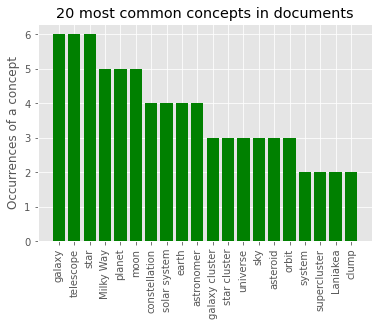

In [6]:
import matplotlib.pyplot as plt

plt.style.use('ggplot')

top20_concepts = list(collection_of_concepts.keys())[:20]
top20_count = list(collection_of_concepts.values())[:20]
x_pos = [i for i, _ in enumerate(top20_concepts)]

plt.bar(x_pos, top20_count, color='green')
plt.ylabel("Occurrences of a concept")
plt.title("20 most common concepts in documents")

plt.xticks(x_pos, top20_concepts, rotation='vertical')

plt.show()

### Step 3: Document classification

Now, we will learn how to classify documents according to the <a href='https://iptc.org/standards/media-topics/'>IPTC Media Topics Taxonomy</a> provided by the Natural Language API. We start with a sample text first to see how to set everything up, and then perform the same action on a dataset.

In [7]:
text = """Strategic acquisitions have been important to the growth of Facebook (FB). 
Mark Zuckerberg founded the company in 2004, and since then it has acquired scores of companies, 
ranging from tiny two-person start-ups to well-established businesses such as WhatsApp. For 2019, 
Facebook reported 2.5 billion monthly active users (MAU) and $70.69 billion in revenue."""
language = 'en'

We can now request to classify the previous text based on the IPTC Media Topics categories:

In [8]:
# Notice: the parameter for resource is specifying what kind of exploration we want to perform on our documents.
# We also need to point out which classificator we are going to use by specifiying "taxonomy".
taxonomy='iptc'
document = client.classification(
    body={"document": {"text": text}}, 
    params={'taxonomy': taxonomy,'language': language})

For each category we can see its label, unique ID and a frequency whitin in the text:

In [9]:
print (f'{"CATEGORY":{27}} {"IPTC ID":{10}} {"FREQUENCY":{8}}\n')

for category in document.categories:
    print (f'{category.label:{27}} {category.id_:{10}}{category.frequency:{8}}')

CATEGORY                    IPTC ID    FREQUENCY

Earnings                    20000178     29.63
Social networking           20000769     21.95


With this new functionality on our dataset, we can retrieve and collect all the IPTC Media Topics categories triggered in the documents:

In [10]:
import os

#This is the path to our dataset, a collection of 22 documents on astronomy
path = 'YOUR_PATH\Astronomy'
collection_of_categories = {}

# We are now iterating on the files folder, retrieving each text to perfom the text analysis on IPTC Media Topics classification
for n, filename in enumerate(os.listdir(path)):
    with open(os.path.join(path, filename), 'r', encoding ='utf8') as f:
        text = f.read()
        document = client.classification(
            body={"document": {"text": text}}, 
            params={'taxonomy': taxonomy,'language': language})
        # We iterate on a text's categories and we store the results in collection_of_categories:
        # a dictionary whose key is the category label and value is the number of documents the category was found in
        for category in document.categories:
            collection_of_categories[category.label] = collection_of_categories.get(category.label, 0) + 1          

Now, in `collection_of_categories` we have each IPTC Media Topics category found and the number of documents in which it was found. We can now visualize a tag cloud of the topics of the dataset:

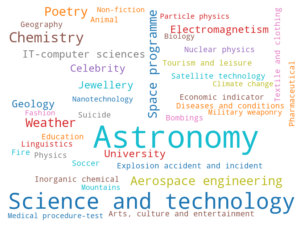

In [42]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

classification_word_cloud = WordCloud(width=800, height=600, background_color='white', colormap='tab10').generate_from_frequencies(collection_of_categories)

# Display the generated image:
plt.imshow(classification_word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

### Conclusion

With expert.ai technology, it's easy to access hidden information in texts such as the most important concepts or the topics they describe. As we have seen, from installation to visualization of meaningful data it takes only a few minutes! </br>
We hope that you enjoyed this tutorial and look forward to learning about the textual esploration you perform using expert.ai NL API.